# MTH416 Neural Networks and Deep Learning - Assignment 2


**Submission requirements：Please convert your completed .ipynb notebook to .pdf
and submit (make sure the PDF file includes your correct answers)； please also  submit the .ipynb file. So, both the PDF and .ipynb files are required.**




In this assignment, you'll train a small convolutional neural network to classify images of clothing items from the FashionMNIST dataset. You wil fill in critical components of a simple PyTorch training pipeline, evaluate the model on the test set, and explore the impact of specific design choices and hyperparameters on the model's performance.

Tasks include:

(a) Read and execute the notebook cells until you reach the training loop section. Here you will complete the function **train** that trains a network for 1 epoch by filling in the missing code snippets. (**20 points**)

(b) Implement the **get_prediction** function which returns the index of the predict class given an image and a network and is called during the evaluation routine. Also implement the accuracy computation in the (**evaluate**) function. (**20 points**)

(c) Here, we bring all of the pieces together to train the network. Instantiate an optimizer to update the weights of the network during training. Run training and validation for 10 epochs and report your final validation accuracy. （**20 points**）

(d) Experiment with **three or more** of the following hyperparameters
/ techniques. （**40 points**）


# Requirements installation


First, let's install everything needed to run this notebook


In [1]:
!pip install Pillow
!pip install -U image
!pip install opencv-python
!pip install tqdm
!pip install torch
!pip install torchvision

from tqdm import tqdm
from io import BytesIO

import cv2
import numpy as np
import PIL.Image
from IPython.display import Image, clear_output, display

# PyTorch will be out main tool for playing with neural networks
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms

# For reproducibility
torch.manual_seed(1234)

# CPU / GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

# Download function for model
import requests
def download(url, fn=None):
    if fn is None:
        fn = url.split('/')[-1]
    r = requests.get(url)
    if r.status_code == 200:
        open(fn, 'wb').write(r.content)
        print("{} downloaded: {:.2f} KB".format(fn, len(r.content) / 1024.0))
    else:
        print("url not found:", url)


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# Problem: Training your own classifier

The goal of this problem is to train a small convolutional neural network to classify images of clothing items from the FashionMNIST dataset. You'll first fill in critical components of a simple PyTorch training pipeline, evaluate the model on the test set, and explore the impact of specific design choices and hyperparameters on the model's performance.

## Building an FashionMNIST Classifier

Using what we have learned, let's build a simple FasionMNIST classifier. Each element of the dataset is a 2-tuple: the 28x28 image and its label.


The [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) library provides a wide range of standard vision datasets and networks with pretrained weights. We will use [the `torchvision.datasets.FashionMNIST` class](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) to easily access the FasionMNIST dataset.

In deep learning, it is often a good idea to normalize network inputs to be centered around zero. We use the [`torchvision.transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) tranform to achieve this. We compose the transforms together using the [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) transform, which allows us to apply multiple transforms sequentially. We provide the following functions to help create the FashionMNIST dataset with these transforms:

In [2]:
def get_transform(split='train'):
    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

def get_dataset(split='train', transform=None):
    return datasets.FashionMNIST(
        'data',
        train=split == 'train',
        download=True,
        transform=transform if transform is not None else transforms.ToTensor(),
    )

def get_dataloaders(batch_size=64, num_workers=2):
    '''Use Pytorch torch.utils.data.DataLoader to load batched data'''
    train_dataset = get_dataset('train', get_transform())
    val_dataset = get_dataset('val', get_transform())
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # shuffle training set
        num_workers=num_workers,  # turns on multi-processing loading so training is not blocked by data loading
        pin_memory=True,  # pin_memory allows faster transfer from CPU to GPU
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, val_dataloader

print('training set size:\t{}'.format(len(get_dataset('train'))))
print('validation set size:\t{}'.format(len(get_dataset('val'))))

# Each element yielded by `train_loader` (a Python iterable) is still a 2-tuple,
# but now consisting of a batched image tensor, and a batched label tensor.
train_loader, _ = get_dataloaders()
images, labels = next(iter(train_loader))

print('batched image tensor shape: {}'.format(images.shape))
print('batched label tensor shape: {}'.format(labels.shape))

training set size:	60000
validation set size:	10000
batched image tensor shape: torch.Size([64, 1, 28, 28])
batched label tensor shape: torch.Size([64])


### Building the Network

We will use a convolutional network for classification. The following architecture is adapted from the famous [LeNet-5](https://ieeexplore.ieee.org/document/726791) [1].

[1] LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.


In [3]:
class MyNet(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        fc1_size=120,
        fc2_size=84,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
        )
        self.fc1 = nn.Linear(in_features=filter2_size * kernel_size ** 2, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = MyNet().to(device)

# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape


torch.Size([32, 10])

### **Problem a: Training Loop**

For classification, we will use the cross-entropy loss [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) to train this network.

We write a function that accepts a PyTorch dataloader, model and optimizer (as well as a device and current epoch), and trains the net for 1 epoch (one full pass through the training set).

The next exercise is to fill in the code below. You can use the following pytorch functions:

-   put data on GPU: [to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html?highlight=#torch.to)
-   clear gradient: [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html?highlight=zero_grad)
-   backward pass: [backward](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html?highlight=backward#torch.autograd.backward)
-   update parameters with a gradient step: [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html?highlight=step#torch.optim.Optimizer.step)



In [4]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a TODO

def accuracy(output, target):
    """Computes the accuracy of the model on the test set.

    Args:
        output: the output of the model
        target: the ground truth labels
    Returns:
        the accuracy of the model on the test set
    """
    with torch.no_grad():
        _, predicted = torch.max(output, 1)
        correct = (predicted == target).sum().item()
    return correct / len(target)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train(dataloader, model, optimizer, epoch):
    model.train()

    train_loss = []
    acc_meter = AverageMeter()
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: Loss (NA) Accuracy (NA %)")
    for batch_idx, (data, target) in batches:
        # TODO: Move data to appropriate device
        data = data.to(device)
        target = target.to(device)  
        
        
        # TODO: Zero out gradients
        optimizer.zero_grad(set_to_none=True)

        # TODO: Compute forward pass, loss, and gradients
        output=model(data)
        loss=F.cross_entropy(output,target)
        torch.autograd.backward(loss)
        
        
        # TODO: Update parameters
        optimizer.step()
        
        
        # TODO: Compute and record accuracy (cf. helper function above)
        acc = None
        acc=accuracy(output,target)   # Use the defined accuracy function
        acc_meter.update(acc)        #Update the average accuracy rate
        train_loss.append(loss.item())  #Record the loss value
        

        batches.set_description(
            "Epoch {:d}: Loss ({:.2e}), Train Accuracy ({:02.0f}%)".format(
                epoch, loss.item(), 100.0 * acc_meter.avg
            )
        )

    return train_loss, acc_meter.avg

## Problem b: Evaluating the Model

Let's also write a function that evaluates our network on the validation set.


In [5]:
########################
#                      #
#       Exercise       #
#                      #
########################

# Fix the places with a TODO


def get_prediction(image, net):
    # TODO!!!  (HINT: use .argmax(dim=-1))
    #   `prediction` should be an integer vector of size equal to the batch size.
    #   Remember that the network outputs logits of the prediction probabilities,
    #   and that the higher the logits, the higher the probability.
    prediction=None
    prediction_all = net(image)
    #Take the index of the maximum value in logits as the prediction category
    prediction = prediction_all.argmax(dim=-1)
    return prediction

def evaluate(dataloader, net):
    total = 0
    correct = 0

    net.eval()  # puts the network in eval mode. this is important when the
    # network has layers that behaves differently in training and
    # evaluation time, e.g., dropout and batch norm.
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():  # gradients are not tracked in this context manager
            # since we are evaluating, gradients are not needed
            # and we can save some time and GPU memory.

            # TODO: Get predictions using function get_prediction
            prediction=get_prediction(image, net) #Use the above-mentioned get_prediction function

            # TODO: Update total and correct
            total = total + label.size(0)
            correct = correct + (prediction == label).sum()
        
            # Hint: Your logic can reflect what's already implemented for you above

    return correct / total


In [6]:
# Without any training, the network accuracy matches that of random guessing: ~10%.
_, val_loader = get_dataloaders(batch_size=32, num_workers=0)
print('At initialization, the network has accuracy {:.4f}%'.format(evaluate(val_loader, net) * 100))


At initialization, the network has accuracy 12.3500%


## Problem c: Putting Everything Together


In [7]:
########################
#                      #
#       Exercise       #
#                      #
########################

###In order to facilitate the analysis of the subsequent questions, I modified some of the code in this part

# Fix the places with a TODO
num_epochs = 10
lr = 0.01
validation_accuracy_original=[]
loss={}
def create_optimizer(net, lr):
    # TODO: Create optimizer 
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    return optimizer

optim = create_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)
loss_original=[] #*Record the training losses
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train_loss, acc =train(train_loader, net, optim, epoch)
    #*The following two lines of code are added to the original code to record 
    #the training loss and accuracy rate, which is convenient for the analysis of subsequent questions
    validation_accuracy_original.append(evaluate(val_loader, net) * 100)
    loss_original.extend(train_loss)#*record the training loss
valid_accuracy = evaluate(val_loader, net) * 100
print('Done! \tValidation Accuracy: {:.4f}%'.format(valid_accuracy))
 

Epoch: 0	Validation Accuracy: 12.3500%


Epoch 0: Loss (5.44e-01), Train Accuracy (67%): 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]


Epoch: 1	Validation Accuracy: 81.3900%


Epoch 1: Loss (4.70e-01), Train Accuracy (84%): 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]


Epoch: 2	Validation Accuracy: 85.1700%


Epoch 2: Loss (4.21e-01), Train Accuracy (86%): 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]


Epoch: 3	Validation Accuracy: 86.5500%


Epoch 3: Loss (2.30e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]


Epoch: 4	Validation Accuracy: 87.4500%


Epoch 4: Loss (3.71e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]


Epoch: 5	Validation Accuracy: 87.9500%


Epoch 5: Loss (4.22e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch: 6	Validation Accuracy: 88.3800%


Epoch 6: Loss (2.47e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch: 7	Validation Accuracy: 88.7600%


Epoch 7: Loss (2.27e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Epoch: 8	Validation Accuracy: 89.0700%


Epoch 8: Loss (4.74e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch: 9	Validation Accuracy: 89.4900%


Epoch 9: Loss (1.80e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Done! 	Validation Accuracy: 89.3500%


## Problem d

We want you to get a feel for the impact of specific design choices on the performance of the network. Experiment with **three or more** of the following hyperparameters / techniques:

-   Data augmentation
-   Weight initialization
-   Number of layers, or number of layer features
-   Type of optimizer
-   Learning rate and/or schedule
-   Regularization

For the techniques you choose, plot the top-1 accuracy of your modified network against the top-1 accuracy of the original network for both the training and validation sets. Try several different hyperparameter values! For example, if you choose to modify the learning rate, you can plot a chart of learning rate vs. top-1 accuracy. Briefly describe the techniques you tried, and suggest an explanation for your results.


This time, we choose the following three hyperparameters for parameter tuning:
* Learning rate
* Type of optimizer 
* Number of layers/number of layer features

We will use the following code to implement the parameter tuning:

## Change the Learning Rate

In [8]:
# Your code for Problem 4d starts from here and you can add as many cells as you'd like to below.

#1、Change the learning rate 2、Change the optimizer type 3、Regularization
results_acc = {}
loss={}
num_epochs = 10
net = MyNet().to(device)#Initialize the model
# Print out results.
for lr in np.arange(0.01,0.004,-0.001):
    net = MyNet().to(device) #Initialize the model
    optim=create_optimizer(net,lr)
    print('Learning rate: {}'.format(lr))
    epoch_train_acc, epoch_val_acc,epoch_train_loss = [], [], []
    for epoch in range(num_epochs):
        train_loss, acc = train(train_loader, net, optim, epoch)
        val_acc = evaluate(val_loader, net)
        epoch_train_acc.append(acc)
        epoch_val_acc.append(val_acc)
        epoch_train_loss.extend(train_loss)#record the training loss for each epoch
    # record the best validation accuracy achieved during cross-validation
    best_val = max(epoch_val_acc)
    results_acc[lr] = epoch_val_acc  # record the validation accuracy for each learning rate
    loss[lr]=epoch_train_loss # record the training loss for each learning rate
    print('best validation accuracy achieved during cross-validation: %f' % best_val)


Learning rate: 0.01


Epoch 9: Loss (1.88e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]


best validation accuracy achieved during cross-validation: 0.896800
Learning rate: 0.009000000000000001


Epoch 9: Loss (3.58e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]


best validation accuracy achieved during cross-validation: 0.892700
Learning rate: 0.008000000000000002


Epoch 9: Loss (2.94e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]


best validation accuracy achieved during cross-validation: 0.890100
Learning rate: 0.007000000000000003


Epoch 9: Loss (3.72e-01), Train Accuracy (91%): 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]


best validation accuracy achieved during cross-validation: 0.893600
Learning rate: 0.006000000000000004


Epoch 9: Loss (1.52e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


best validation accuracy achieved during cross-validation: 0.889900
Learning rate: 0.0050000000000000044


Epoch 9: Loss (2.47e-01), Train Accuracy (90%): 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]


best validation accuracy achieved during cross-validation: 0.889100


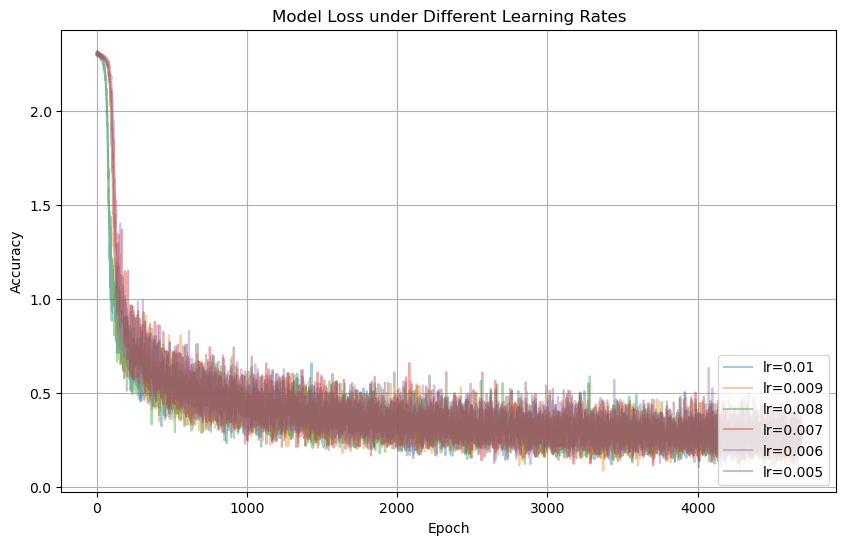

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# set up the x axis
x = np.arange(0, 4690, 1)  
# Plot the training loss graph for each learning rate
for lr, values in loss.items():
    plt.plot(x, values, '-', label=f'lr={round(lr,4)}',alpha=0.4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Loss under Different Learning Rates')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

It can be seen from the above figure that there is no significant difference in the impact of different learning rates on the model loss.

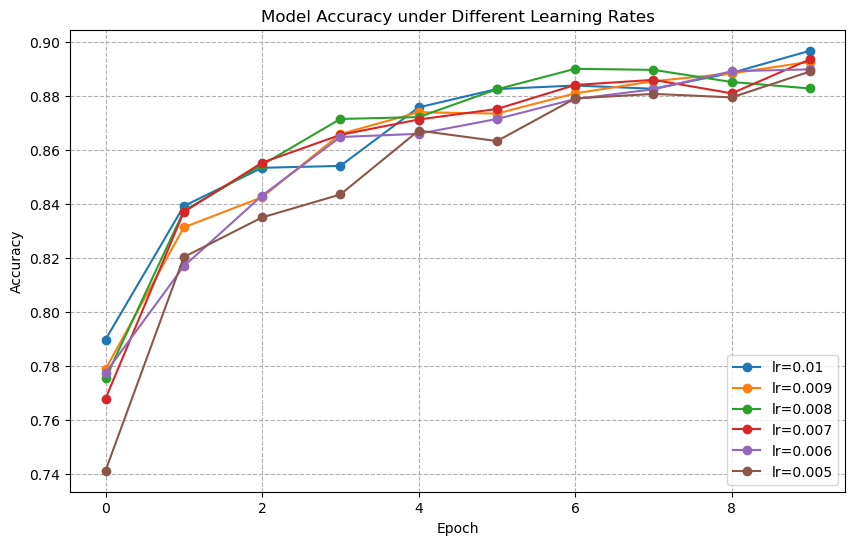

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
x = np.arange(0, 10, 1)  
#Draw the accuracy line for each learning rate
for lr, values in results_acc.items():
    plt.plot(x, values, 'o-', label=f'lr={round(lr,4)}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy under Different Learning Rates')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.show()

It can be seen from the above figure that when the learning rate is 0.01, the model trained 10 times has the highest accuracy, approaching 0.9. When the learning rate is 0.008, the accuracy of the final trained model is the lowest, around 0.89. When the learning rate is 0.005, the growth rate of the model accuracy of the model is the fastest, while when the learning rate is 0.01, the growth rate of the model accuracy is the slowest. For the model of this task, basically, as the learning rate increases, the growth rate of the model's accuracy becomes faster and faster, and the initial model accuracy becomes lower and lower, while the final model accuracy becomes higher and higher.

## Change the optimizer type from SGD to Adam.

I added a line of code for storing the accuracy rate in the previous code and saved it in validation_accuracy_original, as shown below:

The accuracy rate after changing the optimizer to Adam is recorded in new_valid_accuracy for convenient comparison.

In [13]:
###new optimizer
num_epochs = 10
lr = 0.01
net = MyNet().to(device)#Initialize the model
validation_accuracy_new=[]
def create_new_optimizer(net, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-3)
    return optimizer

optim = create_new_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)
loss_new=[]
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train_loss,acc = train(train_loader, net, optim, epoch)
    ###Record the changes of the accuracy valid_accuracy 
    ###and the training loss loss as the learning rate increases
    validation_accuracy_new.append(evaluate(val_loader, net) * 100)
    loss_new.extend(train_loss) #Record the training loss
valid_accuracy = evaluate(val_loader, net) * 100
print('Done! \tValidation Accuracy of new optimizer: {:.4f}%'.format(valid_accuracy))


Epoch: 0	Validation Accuracy: 10.0000%


Epoch 0: Loss (3.55e-01), Train Accuracy (81%): 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]


Epoch: 1	Validation Accuracy: 84.7200%


Epoch 1: Loss (3.91e-01), Train Accuracy (87%): 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch: 2	Validation Accuracy: 86.1000%


Epoch 2: Loss (3.50e-01), Train Accuracy (87%): 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]


Epoch: 3	Validation Accuracy: 87.1300%


Epoch 3: Loss (4.58e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]


Epoch: 4	Validation Accuracy: 87.7800%


Epoch 4: Loss (3.98e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch: 5	Validation Accuracy: 86.6900%


Epoch 5: Loss (3.07e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]


Epoch: 6	Validation Accuracy: 86.2500%


Epoch 6: Loss (3.47e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]


Epoch: 7	Validation Accuracy: 86.5900%


Epoch 7: Loss (2.32e-01), Train Accuracy (88%): 100%|██████████| 469/469 [00:19<00:00, 23.61it/s]


Epoch: 8	Validation Accuracy: 88.0800%


Epoch 8: Loss (3.87e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:19<00:00, 23.64it/s]


Epoch: 9	Validation Accuracy: 87.9500%


Epoch 9: Loss (2.82e-01), Train Accuracy (89%): 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]


Done! 	Validation Accuracy of new optimizer: 86.9200%


In [14]:
print(validation_accuracy_new)


[tensor(84.7200), tensor(86.1000), tensor(87.1300), tensor(87.7800), tensor(86.6900), tensor(86.2500), tensor(86.5900), tensor(88.0800), tensor(87.9500), tensor(86.9200)]


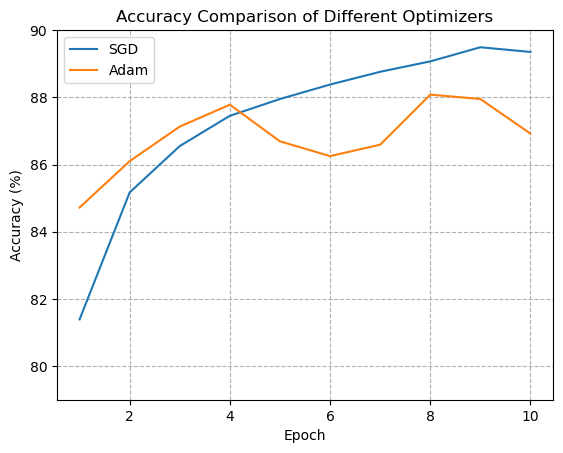

In [15]:
y1 = validation_accuracy_original
y2 = validation_accuracy_new
x = np.arange(1,11)

plt.plot(x, y1, label='SGD')
plt.plot(x, y2, label='Adam')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Optimizers')
plt.legend(loc='best')
plt.grid(True, linestyle='--')
plt.ylim(79, 90) 
plt.show()


It can be seen from the above figure that the accuracy of the model with parameters updated using the SGD optimizer steadily increases along with the number of repeated training epochs, and the accuracy reaches the highest at the 10th time. The accuracy rate of the Adam optimizer in updating parameters reaches the highest at the sixth time, and the accuracy rate of the initial training is much higher than that of the SGD method. However, the increase in the number of training repetisions epos is not obvious. For this model, perhaps the SGD method is more suitable. Some differences between the two methods can also be seen from this figure. If the parameters of SGD are properly tuned, better final accuracy may be achieved, but the convergence speed is relatively slow. The Adam method converges quickly in the early stage and is suitable for complex tasks, but it may fall into local optimal solutions.

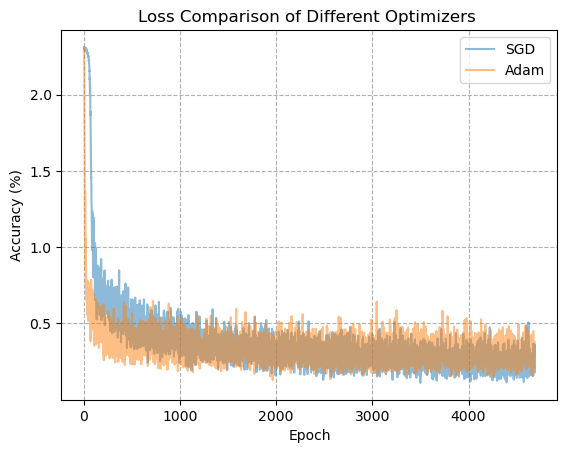

In [15]:
y1 = loss_original
y2 = loss_new
x = np.arange(1,4691)
plt.plot(x, y1, label='SGD',alpha=0.5)
plt.plot(x, y2, label='Adam',alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Loss Comparison of Different Optimizers ')
plt.legend(loc='best')
plt.grid(True, linestyle='--')
plt.show()




As shown in the above figure, the model loss of SDG and Adam is not much different. However, the model loss of SGD decreases at a faster rate and is lower after ten trainings. The model loss of Adam is always at a relatively low level, and the loss is lower at a lower epoch. However, it is slightly higher than the model loss of SGD after ten trainings.

##  Number of layers/number of layer features
We will observe the changes in the model effect by adding or reducing the Number of layers and modifying the number of layer features.
### Add New Layers


In [16]:
class MyNet(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        filter3_size=32,  # The size of the newly added third convolutional layer
        fc1_size=120,
        fc2_size=84,
        fc3_size=42,     # The size of the newly added fourth fully connected layer
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv3 = nn.Conv2d(  # The newly added third convolution layer
            in_channels=filter2_size,
            out_channels=filter3_size,
            kernel_size=kernel_size,
            padding=2,
        )
        #The input size has been modified
        self.fc1 = nn.Linear(in_features=filter3_size * (kernel_size-2) ** 2, out_features=fc1_size) 
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=fc3_size)  # Newly added fully connected layer
        self.fc4 = nn.Linear(in_features=fc3_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv3(out))  # The newly added convolutional layer propagates forward
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))  # The newly added fully connected layer propagates forward
        out = self.fc4(out)
        return out
net = MyNet().to(device)

# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape


torch.Size([32, 10])

In [17]:
###new optimizer
num_epochs = 10
lr = 0.01
net = MyNet().to(device)#Initialize the network
validation_accuracy_new2=[]
def create_optimizer(net, lr):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
    return optimizer

optim = create_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)
loss_3layer=[]
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train_loss,acc=train(train_loader, net, optim, epoch)
    validation_accuracy_new2.append(evaluate(val_loader, net) * 100)
    loss_3layer.extend(train_loss)#record the training loss for each epoch
valid_accuracy = evaluate(val_loader, net) * 100
print('Done! \tValidation Accuracy of new optimizer: {:.4f}%'.format(valid_accuracy))


Epoch: 0	Validation Accuracy: 10.0000%


Epoch 0: Loss (2.30e+00), Train Accuracy (10%): 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Epoch: 1	Validation Accuracy: 10.0000%


Epoch 1: Loss (2.30e+00), Train Accuracy (10%): 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]


Epoch: 2	Validation Accuracy: 10.0000%


Epoch 2: Loss (2.30e+00), Train Accuracy (12%): 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Epoch: 3	Validation Accuracy: 16.2500%


Epoch 3: Loss (2.29e+00), Train Accuracy (27%): 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]


Epoch: 4	Validation Accuracy: 37.1200%


Epoch 4: Loss (1.69e+00), Train Accuracy (29%): 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]


Epoch: 5	Validation Accuracy: 23.4500%


Epoch 5: Loss (1.07e+00), Train Accuracy (52%): 100%|██████████| 469/469 [00:20<00:00, 23.31it/s]


Epoch: 6	Validation Accuracy: 61.5500%


Epoch 6: Loss (6.19e-01), Train Accuracy (66%): 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]


Epoch: 7	Validation Accuracy: 70.3900%


Epoch 7: Loss (7.11e-01), Train Accuracy (72%): 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]


Epoch: 8	Validation Accuracy: 68.6300%


Epoch 8: Loss (5.80e-01), Train Accuracy (74%): 100%|██████████| 469/469 [00:19<00:00, 24.09it/s]


Epoch: 9	Validation Accuracy: 73.9700%


Epoch 9: Loss (4.82e-01), Train Accuracy (75%): 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]


Done! 	Validation Accuracy of new optimizer: 75.9700%


### Reduce The Layers

In [18]:
class MyNet(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        kernel_size=5,
        filter1_size=16,  #change to use larger filter size
        fc1_size=120,
        fc2_size=84,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,  
        )
        #Remove the second convolutional layer
        #The input dimensions of the fully connected layer need to be recalculated
        #After convolution: 28x28 (padding=2 to maintain size)
        #After pooling: 14x14
        fc_input_size = filter1_size * 14 * 14
        
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)  
        out = out.view(out.size(0), -1)  
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

net = MyNet().to(device)

In [19]:
num_epochs = 10
lr = 0.01
net = MyNet().to(device)
validation_accuracy_new3=[]
def create_optimizer(net, lr):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
    return optimizer

optim = create_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)
loss_1layer=[]
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train_loss,acc = train(train_loader, net, optim, epoch)
    validation_accuracy_new3.append(evaluate(val_loader, net) * 100)
    loss_1layer.extend(train_loss)
valid_accuracy = evaluate(val_loader, net) * 100
print('Done! \tValidation Accuracy of new optimizer: {:.4f}%'.format(valid_accuracy))


Epoch: 0	Validation Accuracy: 9.9900%


Epoch 0: Loss (6.57e-01), Train Accuracy (61%): 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch: 1	Validation Accuracy: 74.5300%


Epoch 1: Loss (4.93e-01), Train Accuracy (77%): 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch: 2	Validation Accuracy: 76.7500%


Epoch 2: Loss (4.74e-01), Train Accuracy (80%): 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


Epoch: 3	Validation Accuracy: 78.9800%


Epoch 3: Loss (4.65e-01), Train Accuracy (82%): 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]


Epoch: 4	Validation Accuracy: 82.1300%


Epoch 4: Loss (3.97e-01), Train Accuracy (83%): 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]


Epoch: 5	Validation Accuracy: 83.5500%


Epoch 5: Loss (3.15e-01), Train Accuracy (84%): 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]


Epoch: 6	Validation Accuracy: 84.5500%


Epoch 6: Loss (5.04e-01), Train Accuracy (85%): 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]


Epoch: 7	Validation Accuracy: 84.6800%


Epoch 7: Loss (4.48e-01), Train Accuracy (86%): 100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


Epoch: 8	Validation Accuracy: 84.4800%


Epoch 8: Loss (3.25e-01), Train Accuracy (86%): 100%|██████████| 469/469 [00:20<00:00, 22.55it/s]


Epoch: 9	Validation Accuracy: 85.1400%


Epoch 9: Loss (3.98e-01), Train Accuracy (87%): 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]


Done! 	Validation Accuracy of new optimizer: 86.1100%


Similarly, draw a graph to view the accuracy comparison of the three models after changing the number of model layers

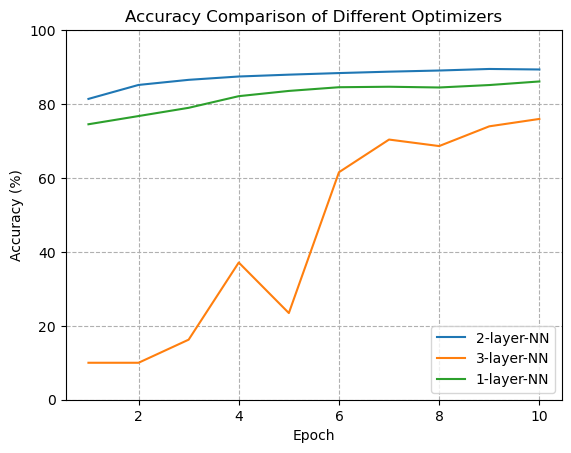

In [20]:
y1 = validation_accuracy_original
y2 = validation_accuracy_new2
y3 = validation_accuracy_new3
x = np.arange(1,11)

plt.plot(x, y1, label='2-layer-NN')
plt.plot(x, y2, label='3-layer-NN')
plt.plot(x, y3, label='1-layer-NN')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Optimizers')
plt.legend(loc='best')
plt.grid(True, linestyle='--')
plt.ylim(0, 100) 
plt.show()

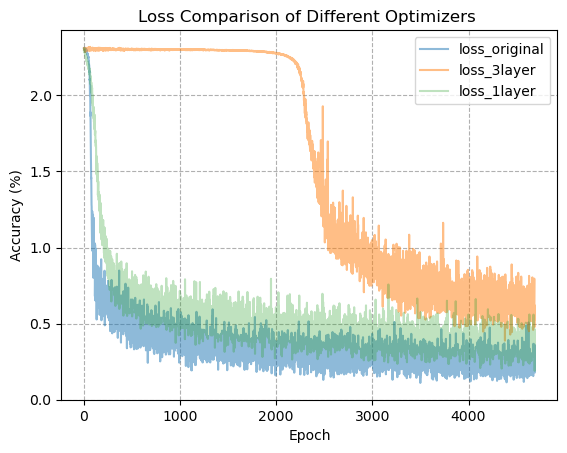

In [21]:
###损失图
y1 = loss_original
y2 = loss_3layer
y3 = loss_1layer
x = np.arange(1,4691)
plt.plot(x, y1, label='loss_original',alpha=0.5)
plt.plot(x, y2, label='loss_3layer',alpha=0.5)
plt.plot(x, y3, label='loss_1layer',alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Loss Comparison of Different Optimizers ')
plt.legend(loc='best')
plt.grid(True, linestyle='--') 
plt.show()

It can be seen from the above figure that the loss of the model after reducing the number of layers is not much different from that of the original two-layer neural network model. Overall, it is slightly higher than that of the two-layer network model. This might be due to the model being too simple.
Also，it can be seen that after increasing the number of layers, the model loss has increased significantly and is significantly higher than the previous model loss. It might be due to the optimization difficulty caused by the overly complex model and the overfitting problem. Attempts should be made to modify the optimizer in combination with the previous code or regularization should be adopted to prevent the model from overfitting. Of course, it is also possible that the number of training sessions is insufficient when the number of layers increases. However, more training sessions may lead to overfitting problems.

In [22]:
class MyNet(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        kernel_size=5,
        filter1_size=5,
        filter2_size=16,
        fc1_size=256. # Increased the first fully connected layer
        fc2_size=128. # Increased the second fully connected layer
        fc3_size=64, # The newly added intermediate fully connected layer
        fc4_size=32, # The newly added intermediate fully connected layer
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=filter1_size,
            kernel_size=kernel_size,
            padding=2,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1_size,
            out_channels=filter2_size,
            kernel_size=kernel_size,
        )
        self.fc1 = nn.Linear(in_features=filter2_size * kernel_size ** 2, out_features=fc1_size)
        self.fc2 = nn.Linear(in_features=fc1_size, out_features=fc2_size)
        self.fc3 = nn.Linear(in_features=fc2_size, out_features=fc3_size)  # new added
        self.fc4 = nn.Linear(in_features=fc3_size, out_features=fc4_size)  # new added
        self.fc5 = nn.Linear(in_features=fc4_size, out_features=num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))  # new added
        out = F.relu(self.fc4(out))  # new added
        out = self.fc5(out)
        return out
    
net = MyNet().to(device)
# This network output a size 10 vector for each input image, as verified below
# using a random input tensor.
net(torch.randn(32, 1, 28, 28, device=device)).shape


torch.Size([32, 10])

In [23]:
num_epochs = 10
lr = 0.01
net = MyNet().to(device)
validation_accuracy_new3=[]
def create_optimizer(net, lr):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-3)
    return optimizer

optim = create_optimizer(net, lr)
train_loader, val_loader = get_dataloaders(batch_size=128)
loss_more_features=[]
for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(val_loader, net) * 100))
    train_loss,acc = train(train_loader, net, optim, epoch)
    validation_accuracy_new3.append(evaluate(val_loader, net) * 100)
    loss_more_features.extend(train_loss)#记录训练损失
valid_accuracy = evaluate(val_loader, net) * 100
print('Done! \tValidation Accuracy of new optimizer: {:.4f}%'.format(valid_accuracy))


Epoch: 0	Validation Accuracy: 10.0000%


Epoch 0: Loss (2.30e+00), Train Accuracy (10%): 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch: 1	Validation Accuracy: 10.0000%


Epoch 1: Loss (2.29e+00), Train Accuracy (11%): 100%|██████████| 469/469 [00:18<00:00, 25.46it/s]


Epoch: 2	Validation Accuracy: 10.3300%


Epoch 2: Loss (2.30e+00), Train Accuracy (17%): 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Epoch: 3	Validation Accuracy: 20.7400%


Epoch 3: Loss (2.28e+00), Train Accuracy (20%): 100%|██████████| 469/469 [00:19<00:00, 24.31it/s]


Epoch: 4	Validation Accuracy: 25.0000%


Epoch 4: Loss (1.80e+00), Train Accuracy (29%): 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]


Epoch: 5	Validation Accuracy: 38.7700%


Epoch 5: Loss (8.64e-01), Train Accuracy (58%): 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]


Epoch: 6	Validation Accuracy: 65.5500%


Epoch 6: Loss (6.66e-01), Train Accuracy (69%): 100%|██████████| 469/469 [00:19<00:00, 24.22it/s]


Epoch: 7	Validation Accuracy: 69.1600%


Epoch 7: Loss (7.30e-01), Train Accuracy (72%): 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]


Epoch: 8	Validation Accuracy: 71.6100%


Epoch 8: Loss (5.24e-01), Train Accuracy (74%): 100%|██████████| 469/469 [00:18<00:00, 24.75it/s]


Epoch: 9	Validation Accuracy: 74.2800%


Epoch 9: Loss (5.00e-01), Train Accuracy (75%): 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


Done! 	Validation Accuracy of new optimizer: 74.4200%


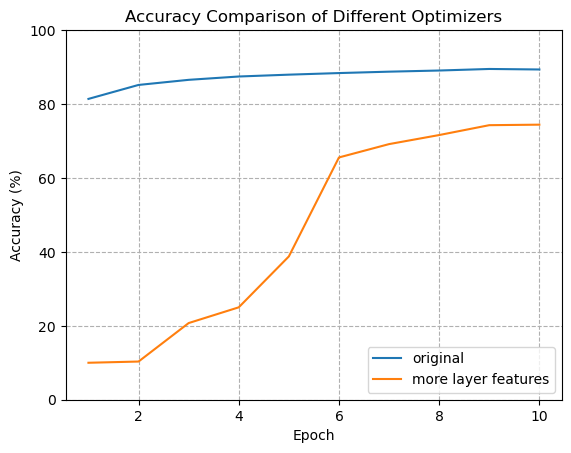

In [26]:
y1 = validation_accuracy_original
y2 = validation_accuracy_new3
x = np.arange(1,11)

plt.plot(x, y1, label='original')
plt.plot(x, y2, label='more layer features')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Optimizers')
plt.legend(loc='best')
plt.grid(True, linestyle='--')
plt.ylim(0, 100) 
plt.show()

It can be seen from the above figure that in the 10 epoch, the model accuracy of "more layer features" is lower. This might be caused by insufficient training times after the model becomes more complex. Or it is due to excessive load that the model overfits.

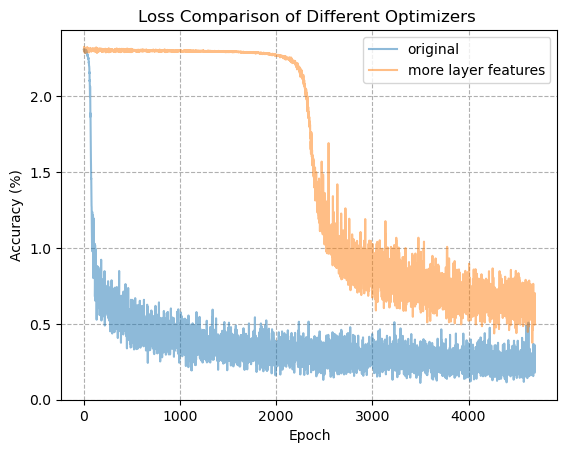

In [29]:
y1 = loss_original
y2 = loss_more_features
x = np.arange(1,4691)
plt.plot(x, y1, label='original',alpha=0.5)
plt.plot(x, y2, label='more layer features',alpha=0.5)


plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Loss Comparison of Different Optimizers ')
plt.legend(loc='best')
plt.grid(True, linestyle='--') 
plt.show()

As can be seen from the above figure, similar to the performance of the model with increased layers in the previous text, the model loss of more layer features is higher than that of less layer features, and its decline is smoother.